In [1]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import wandb

wandb.init(project="huggingface", mode="disabled")

In [2]:
!pip install transformers

In [3]:
!pip install datasets

In [4]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [8]:
from transformers import pipeline
from transformers import AutoFeatureExtractor, DefaultDataCollator, AutoModelForImageClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from evaluate import load
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
from collections import Counter
from copy import deepcopy

In [6]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    RandomRotation,
                                    ToTensor)

##Data preparation

In [10]:
#Data loading
dataset = load_dataset("beans", split="train")
dataset_500 = dataset.train_test_split(train_size=500, stratify_by_column="labels")["train"]

#20% validation
#80% training
beans = dataset_500.train_test_split(test_size=0.2)
beans_train=beans["train"]
beans_val=beans["test"]

test_ds = load_dataset("beans")["test"]
beans_test = deepcopy(test_ds)

In [11]:
labels = beans_train.features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [12]:
id2label

{'0': 'angular_leaf_spot', '1': 'bean_rust', '2': 'healthy'}

In [13]:
# Verify that the labels in the training set have similar distributions.

label_counts = Counter(beans_train["labels"])
total = len(beans_train)
for label, count in label_counts.items():
    print(f"Label {label}: {count} examples ({count/total*100:.2f}%)")

Label 2: 133 examples (33.25%)
Label 1: 134 examples (33.50%)
Label 0: 133 examples (33.25%)


In [14]:
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
label_counts = Counter(beans_val["labels"])
total = len(beans_val)
for label, count in label_counts.items():
    print(f"Label {label}: {count} examples ({count/total*100:.2f}%)")

Label 0: 34 examples (34.00%)
Label 1: 34 examples (34.00%)
Label 2: 32 examples (32.00%)


In [16]:
label_counts = Counter(beans_test["labels"])
total = len(beans_test)
for label, count in label_counts.items():
    print(f"Label {label}: {count} examples ({count/total*100:.2f}%)")

Label 0: 43 examples (33.59%)
Label 1: 43 examples (33.59%)
Label 2: 42 examples (32.81%)


#### Feature extractor selection:

In [17]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [18]:
size = (feature_extractor.size["height"], feature_extractor.size["width"])

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std) #Normalizar
_bean_train_transforms = Compose([RandomResizedCrop(size), RandomRotation(0.5), ToTensor(), normalize])
_bean_val_transforms = Compose([Resize(size), CenterCrop(size), ToTensor(), normalize])

def beans_train_transforms(examples):
    examples["pixel_values"] = [_bean_train_transforms(img.convert("RGB")) for img in examples["image"]] #Se transforma a tensor
    del examples["image"]
    return examples

def beans_val_transforms(examples):
    examples["pixel_values"] = [_bean_val_transforms(img.convert("RGB")) for img in examples["image"]] #Se transforma a tensor
    del examples["image"]
    return examples

beans_train = beans_train.with_transform(beans_train_transforms)
beans_val=beans_val.with_transform(beans_val_transforms)
beans_test=beans_test.with_transform(beans_val_transforms)

In [19]:
data_collator = DefaultDataCollator()

### Model selection

In [20]:
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training parameters

In [21]:
training_args = TrainingArguments(
    f"test-beans",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=beans_train,
    eval_dataset=beans_val,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

### Training

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.422464,0.900000
2,No log,0.368030,0.900000


TrainOutput(global_step=80, training_loss=0.39932277202606203, metrics={'train_runtime': 1649.7268, 'train_samples_per_second': 0.485, 'train_steps_per_second': 0.048, 'total_flos': 6.19941473206272e+16, 'train_loss': 0.39932277202606203, 'epoch': 2.0})

### Evaluation

In [34]:
outputs = trainer.predict(beans_test)
print(outputs.metrics)

{'test_loss': 0.37928926944732666, 'test_accuracy': 0.9453125, 'test_runtime': 101.8461, 'test_samples_per_second': 1.257, 'test_steps_per_second': 0.314}


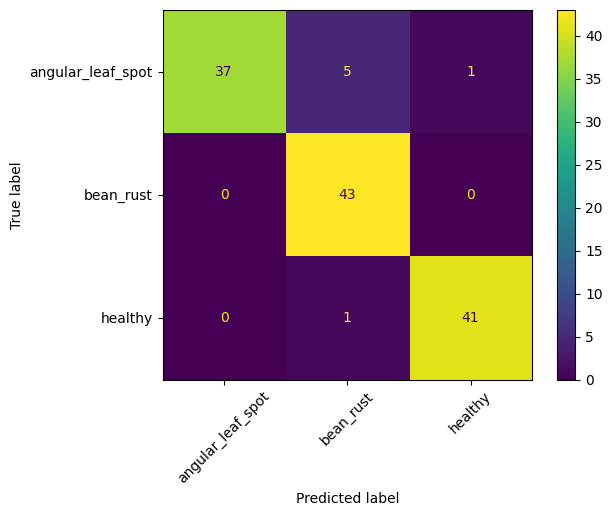

In [35]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = beans["train"].features["labels"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [36]:
beans_test

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 128
})

In [37]:
print(beans_test[0]["labels"])
print(beans_test[50]["labels"])
print(beans_test[100]["labels"])

0
1
2


In [49]:
print(y_pred[0])
print(y_pred[50])
print(y_pred[100])

0
1
2


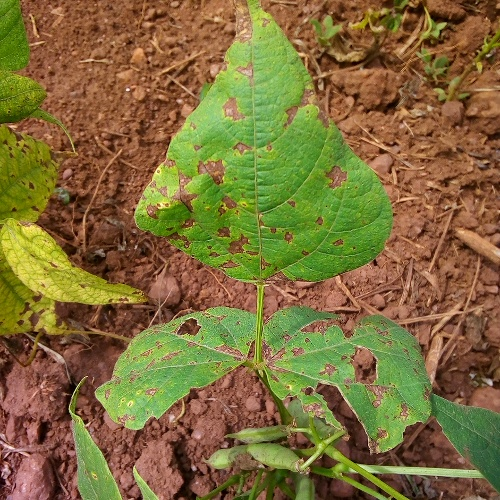

In [50]:
test_ds[0]["image"]

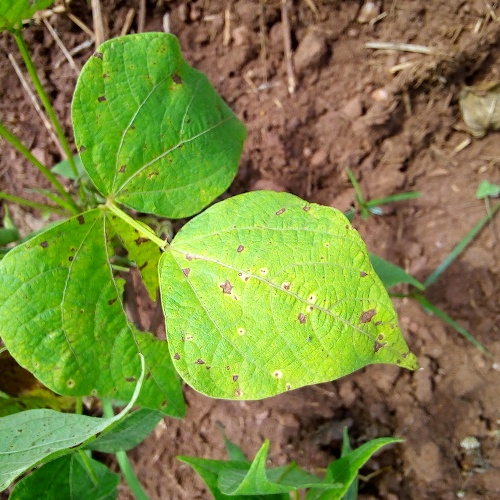

In [51]:
test_ds[50]["image"]

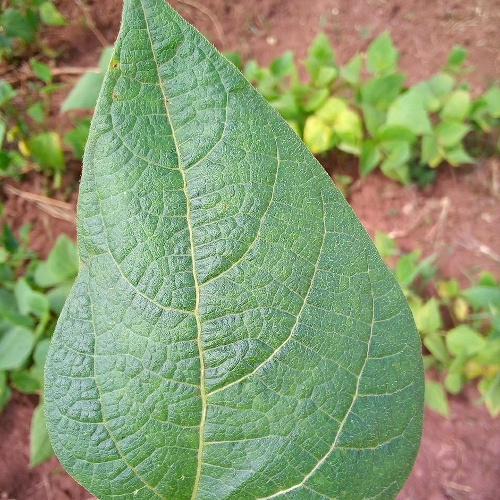

In [52]:
test_ds[100]["image"]